# Robotics, Vision & Control 3e: for Python
## Chapter 3: Time and Motion

In [2]:
try:
    import google.colab
    print('Running on CoLab')
    COLAB = True
    !pip install roboticstoolbox-python>=1.0.2
    !pip install --no-deps rvc3python
except ModuleNotFoundError:
    COLAB = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"
from IPython.display import HTML

# add RTB examples folder to the path
import sys
import os.path
import roboticstoolbox as rtb
import RVC3
sys.path.append(os.path.join(rtb.__path__[0], 'examples'))
sys.path.append(os.path.join(RVC3.__path__[0], 'examples'))

# standard imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from math import pi
np.set_printoptions(
    linewidth=120, formatter={
        'float': lambda x: f"{0:8.4g}" if abs(x) < 1e-10 else f"{x:8.4g}"})
np.random.seed(0)
from spatialmath import *
from spatialmath.base import *
from roboticstoolbox import quintic, trapezoidal, mtraj, mstraj, xplot, ctraj

Running on CoLab
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 KB 3.7 MB/s eta 0:00:00


# 3.1 Time-Varying Pose


## 3.1.3 Transforming Spatial Velocities


In [3]:
aTb = SE3.Tx(-2) * SE3.Rz(-pi/2) * SE3.Rx(pi/2);

In [4]:
bV = [1, 2, 3, 4, 5, 6];

In [5]:
aJb = aTb.jacob();
aJb.shape
aV = aJb @ bV

array([      -3,       -1,        2,       -6,       -4,        5])

In [6]:
aV = aTb.Ad() @ [1, 2, 3, 0, 0, 0]

array([      -3,       -1,        2,        0,        0,        0])

In [7]:
aV = aTb.Ad() @ [0, 0, 0, 1, 0, 0]

array([       0,        0,        2,        0,       -1,        0])

In [8]:
aV = aTb.Ad() @ [1, 2, 3, 1, 0, 0]

array([      -3,       -1,        4,        0,       -1,        0])

## 3.1.4 Incremental Rotation


In [9]:
rotx(0.001)

array([[       1,        0,        0],
       [       0,        1,   -0.001],
       [       0,    0.001,        1]])

In [10]:
import time
Rexact = np.eye(3); Rapprox = np.eye(3);  # null rotation
w = np.array([1, 0, 0]);   # rotation of 1rad/s about x-axis
dt = 0.01;                 # time step
t0 = time.process_time();
for i in range(100):  # exact integration over 100 time steps
  Rexact = Rexact @ trexp(skew(w*dt));  # update by composition
print(time.process_time() - t0)

t0 = time.process_time();
for i in range(100):  # approximate integration over 100 time steps
  Rapprox = Rapprox + Rapprox @ skew(w*dt);  # update by addition
print(time.process_time() - t0)

0.022128931999997548
0.003372775999999078


In [11]:
np.linalg.det(Rapprox) - 1

0.010049662092876055

In [12]:
np.linalg.det(Rexact) - 1

-2.886579864025407e-15

In [13]:
tr2angvec(trnorm(Rexact))

(1.0, array([       1,        0,        0]))

In [14]:
tr2angvec(trnorm(Rapprox))

(0.999966668666524, array([       1,        0,        0]))

# 3.2 Accelerating Bodies and Reference Frames


## 3.2.1 Dynamics of Moving Bodies


In [15]:
J = np.array([[ 2, -1, 0],
              [-1,  4, 0],
              [ 0,  0, 3]]);
orientation = UnitQuaternion();  # identity quaternion
w = 0.2 * np.array([1, 2, 2]);

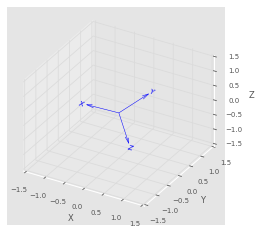

In [16]:
dt = 0.05;  # time step
def update():
  global orientation, w
  for t in np.arange(0, 10, dt):
     wd = -np.linalg.inv(J) @ (np.cross(w, J @ w))  # (3.12)
     w += wd * dt
     orientation *= UnitQuaternion.EulerVec(w * dt)
     yield orientation.R

plt.close("all")
if COLAB:
  anim = tranimate(update(), dims=[-1.5,1.5,-1.5,1.5,-1.5,1.5])
  HTML(vid:=anim.to_html5_video())
else:
  tranimate(update(), dims=[-1.5,1.5,-1.5,1.5,-1.5,1.5])


## 3.2.2 Transforming Forces and Torques


In [17]:
bW = [1, 2, 3, 0, 0, 0];

In [18]:
aW = aTb.inv().Ad().T @ bW

array([      -3,       -1,        2,        0,        4,        2])

# 3.3 Creating Time-Varying Pose


## 3.3.1 Smooth One-Dimensional Trajectories


In [19]:
traj = quintic(0, 1, np.linspace(0, 1, 50));

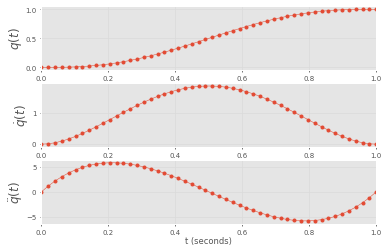

In [20]:
traj.plot();

In [21]:
quintic(0, 1, np.linspace(0, 1, 50), qd0=10, qdf=0);

In [22]:
qd = traj.qd;
qd.mean() / qd.max()

0.523102222222222

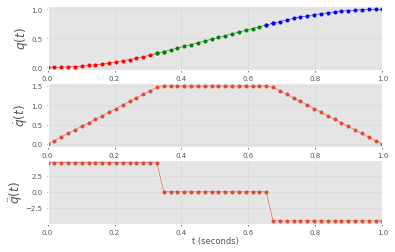

In [23]:
traj = trapezoidal(0, 1, np.linspace(0, 1, 50));
traj.plot();

In [24]:
traj.qd.max()

1.5

In [25]:
traj1_2 = trapezoidal(0, 1, np.linspace(0, 1, 50), V=1.2);
traj2_0 = trapezoidal(0, 1, np.linspace(0, 1, 50), V=2);

## 3.3.2 Multi-Axis Trajectories


In [26]:
traj = mtraj(trapezoidal, [0, 2], [1, -1], 50);

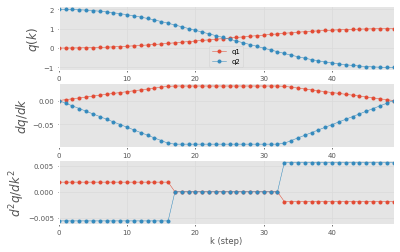

In [27]:
traj.plot();

In [28]:
T = SE3.Rand()
q = np.hstack([T.t, T.rpy()])

array([ 0.09763,   0.4304,   0.2055,    2.777,   -1.125,    1.781])

## 3.3.3 Multi-Segment Trajectories


In [14]:
via = SO2(30, unit="deg") * np.array([[-1, 1, 1, -1, -1], [1, 1, -1, -1, 1]]);
traj0 = mstraj(via.T, dt=0.2, tacc=0, qdmax=[2, 1]);

/usr/local/lib/python3.8/dist-packages/roboticstoolbox/tools/trajectory.py:550: RuntimeWarning: invalid value encountered in true_divide
  ts = t.flatten() / tscal


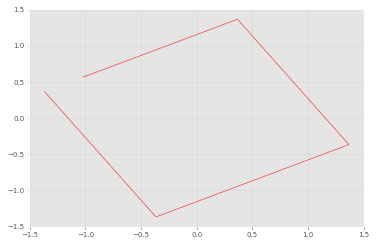

In [18]:
# xplot(traj0.q[:, 0], traj0.q[:, 1], color="red");
plt.plot(traj0.q[:, 0], traj0.q[:, 1], color="red");

In [16]:
traj2 = mstraj(via.T, dt=0.2, tacc=2, qdmax=[2, 1]);

In [17]:
len(traj0), len(traj2)

(28, 80)

## 3.3.4 Interpolation of Orientation in 3D


In [33]:
R0 = SO3.Rz(-1) * SO3.Ry(-1);
R1 = SO3.Rz(1) * SO3.Ry(1);

In [34]:
rpy0 = R0.rpy(); rpy1 = R1.rpy();

In [35]:
traj = mtraj(quintic, rpy0, rpy1, 50);

In [36]:
pose = SO3.RPY(traj.q);
len(pose)

50

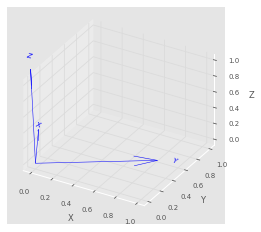

In [37]:
pose.animate();

In [38]:
q0 = UnitQuaternion(R0); q1 = UnitQuaternion(R1);

In [39]:
qtraj = q0.interp(q1, 50);
len(qtraj)

50

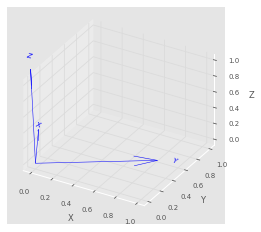

In [40]:
qtraj.animate()

### 3.3.4.1 Direction of Rotation


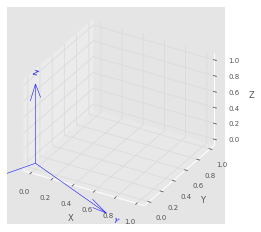

In [41]:
q0 = UnitQuaternion.Rz(-2); q1 = UnitQuaternion.Rz(2);
q = q0.interp(q1, 50);
q.animate()

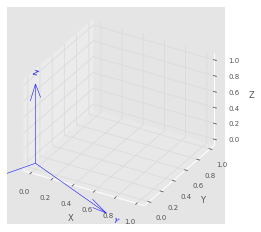

In [42]:
q = q0.interp(q1, 50, shortest=True);
q.animate()

## 3.3.5 Cartesian Motion in 3D


In [43]:
T0 = SE3.Trans([0.4, 0.2, 0]) * SE3.RPY(0, 0, 3);
T1 = SE3.Trans([-0.4, -0.2, 0.3]) * SE3.RPY(-pi/4, pi/4, -pi/2);

In [44]:
T0.interp(T1, 0.5)

   0.09754  -0.702     0.7055    0         
   0.702     0.551     0.4512    0         
  -0.7055    0.4512    0.5465    0.15      
   0         0         0         1         


In [45]:
Ts = T0.interp(T1, 51);

In [46]:
len(Ts)

51

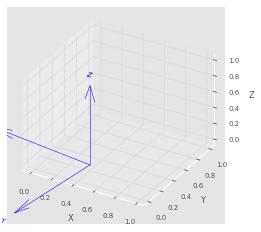

In [47]:
Ts.animate()

In [48]:
Ts[25]

   0.09754  -0.702     0.7055    0         
   0.702     0.551     0.4512    0         
  -0.7055    0.4512    0.5465    0.15      
   0         0         0         1         


In [49]:
P = Ts.t;
P.shape

(51, 3)

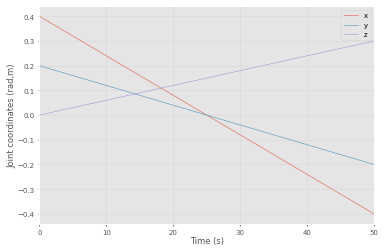

In [50]:
xplot(P, labels="x y z");

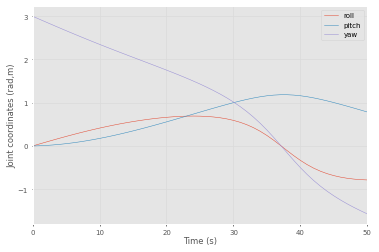

In [51]:
rpy = Ts.rpy();
xplot(rpy, labels="roll pitch yaw");

In [52]:
Ts = T0.interp(T1, trapezoidal(0, 1, 50).q);

In [53]:
Ts = ctraj(T0, T1, 50);

# 3.4 Application: Inertial Navigation


## 3.4.1 Gyroscopes


### 3.4.1.1 How Gyroscopes Work


### 3.4.1.2 Estimating Orientation


In [4]:
from imu_data import IMU
true, _ = IMU()

In [5]:
orientation = UnitQuaternion();  # identity quaternion

In [6]:
for w in true.omega[:-1]:
  next = orientation[-1] @ UnitQuaternion.EulerVec(w * true.dt);
  orientation.append(next);
len(orientation)

400

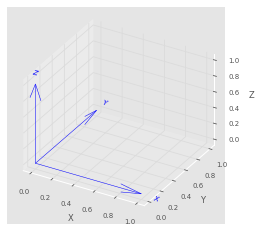

In [7]:
orientation.animate(time=true.t)

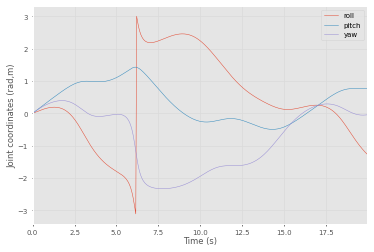

In [8]:
xplot(true.t, orientation.rpy(), labels="roll pitch yaw");

## 3.4.2 Accelerometers


### 3.4.2.1 How Accelerometers Work


### 3.4.2.2 Estimating Pose and Body Acceleration


## 3.4.3 Magnetometers


### 3.4.3.1 How Magnetometers Work


### 3.4.3.2 Estimating Heading


## 3.4.4 Inertial Sensor Fusion


In [9]:
from imu_data import IMU
true, imu = IMU()

In [10]:
q = UnitQuaternion();
for wm in imu.gyro[:-1]:
  q.append(q[-1] @ UnitQuaternion.EulerVec(wm * imu.dt))

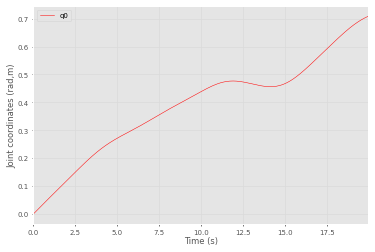

In [11]:
xplot(true.t, q.angdist(true.orientation), color="red");

In [12]:
kI = 0.2; kP = 1;
b = np.zeros(imu.gyro.shape);
qcf = UnitQuaternion();
data = zip(imu.gyro[:-1], imu.accel[:-1], imu.magno[:-1]);
for k, (wm, am, mm) in enumerate(data):
  qi = qcf[-1].inv()
  sR = np.cross(am, qi * true.g) + np.cross(mm, qi * true.B)
  wp = wm - b[k,:] + kP * sR
  qcf.append(qcf[k] @ UnitQuaternion.EulerVec(wp * imu.dt))
  b[k+1,:] = b[k,:] - kI * sR * imu.dt

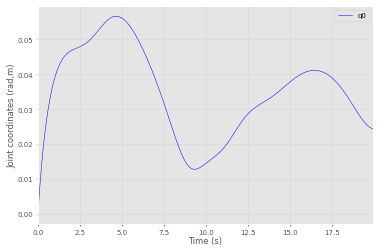

In [13]:
xplot(true.t, qcf.angdist(true.orientation), color="blue");